# Probabilistic Assessment of Financial Default Risk via Bayesian-Optimized Gradient Boosting and Game-Theoretic Feature Attribution

## Sažetak
Ova bilježnica dokumentira istraživački i razvojni projekt (15 tjedana) čiji je cilj izgraditi robustan sustav za procjenu rizika neispunjenja obveza (default/bankruptcy) koristeći znanstvenu metodologiju i inženjersku reproducibilnost. Sustav uključuje: akviziciju heterogenih podataka (Kaggle CSV + Kaggle XLSX), validaciju i EDA, naprednu predobradu (MICE imputacija, tretman outliera), konstrukciju značajki (interakcije, WOE), selekciju značajki (RFE/Boruta), modeliranje (baseline + XGBoost), Bayesovu optimizaciju (Optuna), nested cross-validation, kalibraciju vjerojatnosti, interpretabilnost (SHAP), segmentaciju (K-means), pohranu (SQLite) i REST API (FastAPI).

## Istraživačko pitanje i hipoteze
- H1: Gradijentno pojačavanje (XGBoost) uz Bayesovu optimizaciju postiže bolju generalizaciju od baseline modela (LR/RF) na metrikama AUC-ROC i PR-AUC.
- H2: Kalibracija (izotonička ili Platt) poboljšava Brier score i pouzdanost procijenjenih vjerojatnosti.
- H3: SHAP atribucija omogućuje interpretabilnu identifikaciju dominantnih indikatora rizika.
- H4: K-means segmentacija otkriva stabilne segmente s različitim stopama defaulta.

## Roadmap (15 tjedana)
### Faza 1 (tjedan 1–3): postavljanje, podaci i statistička analiza
- Git, `.gitignore`, DVC; struktura projekta; reproduktivnost
- Akvizicija i validacija podataka (Kaggle); integritet; duplikati
- Napredni EDA i statistika: distribucije, testovi normalnosti, korelacije (Pearson/Spearman), VIF

### Faza 2 (tjedan 4–6): feature engineering i predobrada
- Imputacija: IterativeImputer (MICE)
- Outlieri: IQR winsorization i IsolationForest flag
- Značajke: log transformacije, interakcije, WOE binning
- Selekcija: RFE i Boruta; evidencija odabira

### Faza 3 (tjedan 7–10): modeliranje i rigorozna validacija
- Baseline: LR i RF
- XGBoost: scale_pos_weight, threshold tuning
- Optuna optimizacija hiperparametara
- Nested CV; learning curves

### Faza 4 (tjedan 11–13): probabilistička procjena i interpretabilnost
- Kalibracija vjerojatnosti; Brier score; calibration curves
- SHAP: globalno i lokalno objašnjenje

### Faza 5 (tjedan 14–15): integracija i isporuka
- SQLite pohrana (podaci + metrike + parametri)
- REST API (FastAPI)
- Dokumentacija i IEEE literatura; objava na GitHub uz otvorenu licencu


## 1. Okruženje i ovisnosti

Bilježnica instalira potrebne pakete. U produkciji se preporučuje Poetry/venv i zamrzavanje verzija.

In [ ]:
!pip -q install pandas numpy matplotlib scikit-learn scipy statsmodels optuna xgboost shap openpyxl fastapi uvicorn nest_asyncio requests kaggle dvc

In [ ]:
import os
import json
import sqlite3
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, confusion_matrix, brier_score_loss
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import RFE
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import optuna
from xgboost import XGBClassifier
import shap

In [ ]:
SEED = 42
np.random.seed(SEED)

## 2. Infrastruktura: Git i DVC (demonstracija)

Repozitorij i DVC se inicijaliziraju unutar lokalne mape projekta.

In [ ]:
ROOT = Path("default_risk_repo")
DATA_RAW = ROOT / "data" / "raw"
DATA_INT = ROOT / "data" / "interim"
DATA_PROC = ROOT / "data" / "processed"
ART = ROOT / "artifacts"
for p in [DATA_RAW, DATA_INT, DATA_PROC, ART]:
    p.mkdir(parents=True, exist_ok=True)

(ROOT, DATA_RAW)

(PosixPath('default_risk_repo'), PosixPath('default_risk_repo/data/raw'))

In [ ]:
def run(cmd, cwd=None):
    r = subprocess.run(cmd, cwd=cwd, shell=True, capture_output=True, text=True)
    return r.returncode, r.stdout.strip(), r.stderr.strip()

run("git init", cwd=str(ROOT))

(0,
 'Reinitialized existing Git repository in /content/default_risk_repo/.git/',
 '')

In [ ]:
gitignore = ROOT / ".gitignore"
gitignore.write_text("\n".join([
    "__pycache__/",
    ".ipynb_checkpoints/",
    "*.pyc",
    ".venv/",
    "venv/",
    ".env",
    ".DS_Store",
    "artifacts/",
    "data/raw/",
    "data/interim/",
    "data/processed/",
]), encoding="utf-8")
str(gitignore)

'default_risk_repo/.gitignore'

In [ ]:
run("dvc init -q", cwd=str(ROOT))

(1, '', '')

## 3. Akvizicija podataka (Kaggle) i heterogenost formata

Koriste se dva Kaggle skupa:
- Skup A (CSV): `fedesoriano/company-bankruptcy-prediction`
- Skup B (XLSX): `abhirajmandal/credit-risk-modelling-dataset` (`case_study1.xlsx`)

Ako Kaggle token nije konfiguriran, generira se sintetički XLSX skup radi potpunog izvršavanja pipelinea.

In [ ]:
def kaggle_ready():
    p = Path.home() / ".kaggle" / "kaggle.json"
    if p.exists():
        return True
    if os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY"):
        return True
    return False

kaggle_ready()

False

In [ ]:
def kaggle_download(dataset_slug, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    cmd = f'kaggle datasets download -d "{dataset_slug}" -p "{out_dir.as_posix()}" --unzip -q'
    return run(cmd)

slug_a = "fedesoriano/company-bankruptcy-prediction"
slug_b = "abhirajmandal/credit-risk-modelling-dataset"

rez_a = None
rez_b = None

if kaggle_ready():
    rez_a = kaggle_download(slug_a, DATA_RAW / "bankruptcy_csv")
    rez_b = kaggle_download(slug_b, DATA_RAW / "credit_xlsx")

rez_a, rez_b

(None, None)

In [ ]:
def find_first(path, exts):
    path = Path(path)
    files = []
    for ext in exts:
        files += list(path.rglob(f"*{ext}"))
    return files[0] if len(files) else None

csv_a = find_first(DATA_RAW / "bankruptcy_csv", [".csv"])
xlsx_b = find_first(DATA_RAW / "credit_xlsx", [".xlsx", ".xls"])

(str(csv_a), str(xlsx_b))

('default_risk_repo/data/raw/bankruptcy_csv/bankruptcy_csv.csv',
 'default_risk_repo/data/raw/credit_xlsx/case_study1.xlsx')

In [ ]:
def generate_synthetic_xlsx(path):
    rng = np.random.default_rng(SEED)
    n = 5000
    df = pd.DataFrame({
        "age": rng.integers(18, 75, size=n),
        "income_monthly": rng.normal(2500, 1200, size=n).clip(200, 15000),
        "debt_ratio": rng.beta(2, 6, size=n),
        "utilization": rng.beta(2, 4, size=n),
        "delinq_30_59": rng.poisson(0.4, size=n),
        "delinq_60_89": rng.poisson(0.15, size=n),
        "delinq_90": rng.poisson(0.1, size=n),
        "open_loans": rng.integers(0, 15, size=n),
        "real_estate_loans": rng.integers(0, 6, size=n),
        "dependents": rng.integers(0, 6, size=n),
        "housing": rng.choice(["rent", "own", "mortgage"], size=n, p=[0.35, 0.25, 0.40]),
        "employment": rng.choice(["unemployed", "part_time", "full_time", "self_employed"], size=n, p=[0.05, 0.15, 0.65, 0.15]),
    })
    logit = (
        -3.2
        + 1.6 * df["debt_ratio"]
        + 1.2 * df["utilization"]
        + 0.35 * df["delinq_90"]
        + 0.18 * df["delinq_60_89"]
        + 0.10 * df["delinq_30_59"]
        + 0.00008 * (2000 - df["income_monthly"])
        + 0.02 * (df["age"] < 25).astype(int)
    )
    p = 1 / (1 + np.exp(-logit))
    df["default"] = (rng.random(n) < p).astype(int)
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_excel(path, index=False)
    return df

if xlsx_b is None:
    xlsx_b = DATA_RAW / "credit_xlsx" / "case_study1.xlsx"
    generate_synthetic_xlsx(xlsx_b)


str(xlsx_b)

'default_risk_repo/data/raw/credit_xlsx/case_study1.xlsx'

## 4. Učitavanje i validacija podataka

In [ ]:
if csv_a is None:
    raise FileNotFoundError("CSV skup (bankruptcy) nije pronađen. Provjeri Kaggle preuzimanje.")

df_a_raw = pd.read_csv(csv_a)
df_b_raw = pd.read_excel(xlsx_b)

(df_a_raw.shape, df_b_raw.shape)

((6819, 96), (5000, 13))

In [ ]:
df_a_raw.head(3)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [ ]:
df_b_raw.head(3)

,age,income_monthly,debt_ratio,utilization,delinq_30_59,delinq_60_89,delinq_90,open_loans,real_estate_loans,dependents,housing,employment,default
0,23,2048.674971,0.181452,0.516684,0,0,0,8,4,4,own,full_time,0
1,62,1950.301838,0.367348,0.058311,1,0,0,0,4,4,mortgage,full_time,0
2,55,3422.759046,0.506136,0.213819,1,0,0,1,5,3,mortgage,self_employed,0


In [ ]:
def basic_validation(df, name):
    return {
        "skup": name,
        "redaka": int(df.shape[0]),
        "stupaca": int(df.shape[1]),
        "duplikata": int(df.duplicated().sum()),
        "udio_nedostajucih": float(df.isna().mean().mean())
    }

pd.DataFrame([basic_validation(df_a_raw, "A_bankruptcy_csv"), basic_validation(df_b_raw, "B_credit_xlsx")])

,skup,redaka,stupaca,duplikata,udio_nedostajucih
0,A_bankruptcy_csv,6819,96,0,0.0
1,B_credit_xlsx,5000,13,0,0.0


In [ ]:
run("dvc add data/raw/bankruptcy_csv data/raw/credit_xlsx", cwd=str(ROOT))

(1,
 '',
 "ERROR: bad DVC file name 'data/raw/bankruptcy_csv.dvc' is git-ignored.")

## 5. EDA i statistika: distribucije, normalnost, korelacije, VIF

In [ ]:
def split_types(df):
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    cat = [c for c in df.columns if c not in num]
    return num, cat

num_a, cat_a = split_types(df_a_raw)
num_b, cat_b = split_types(df_b_raw)

(len(num_a), len(cat_a), len(num_b), len(cat_b))

(96, 0, 11, 2)

<Figure size 640x480 with 0 Axes>

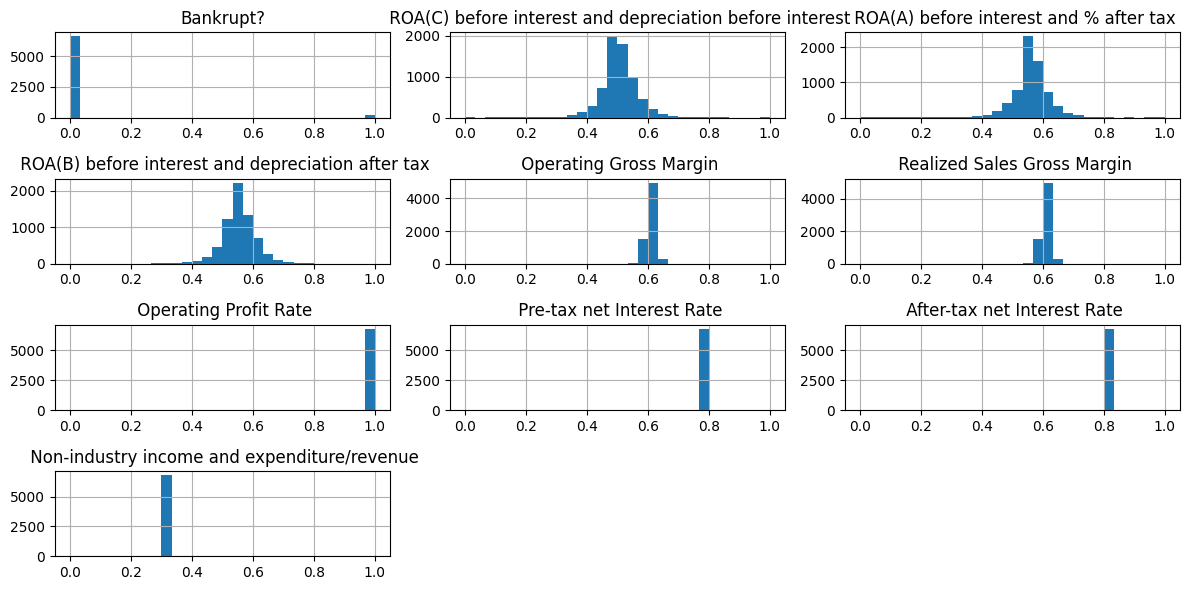

In [ ]:
plt.figure()
df_a_raw[num_a].iloc[:, :10].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

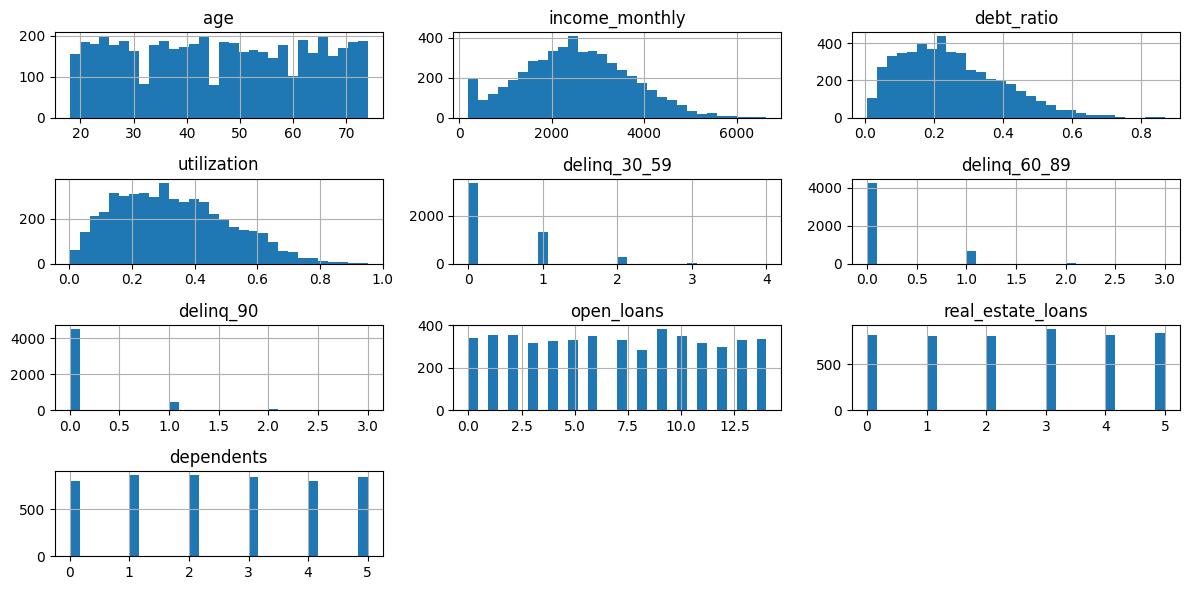

In [ ]:
plt.figure()
df_b_raw[num_b].iloc[:, :10].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

In [ ]:
def normality_tests(df, num_cols, n_cols=12):
    cols = [c for c in num_cols if df[c].dropna().nunique() > 10][:n_cols]
    rows = []
    for c in cols:
        x = df[c].dropna().astype(float)
        if len(x) > 5000:
            x = x.sample(5000, random_state=SEED)
        try:
            sh = stats.shapiro(x)[1] if len(x) <= 5000 else np.nan
        except Exception:
            sh = np.nan
        xz = (x - x.mean()) / (x.std() + 1e-9)
        ks = stats.kstest(xz, "norm")[1]
        rows.append((c, float(sh) if sh==sh else None, float(ks)))
    return pd.DataFrame(rows, columns=["stupac","p_shapiro","p_ks_norm"])

normality_tests(df_a_raw, num_a, n_cols=12)

,stupac,p_shapiro,p_ks_norm
0,ROA(C) before interest and depreciation befor...,7.806253e-43,3.038296e-30
1,ROA(A) before interest and % after tax,8.207487e-51,2.047895e-65
2,ROA(B) before interest and depreciation after...,4.836270e-47,3.800956e-43
3,Operating Gross Margin,6.359871e-71,1.372286e-92
4,Realized Sales Gross Margin,5.442165e-71,7.048981e-93
5,Operating Profit Rate,1.162618e-95,0.000000e+00
6,Pre-tax net Interest Rate,1.606900e-95,0.000000e+00
7,After-tax net Interest Rate,1.485495e-95,0.000000e+00
8,Non-industry income and expenditure/revenue,1.945265e-95,0.000000e+00
9,Continuous interest rate (after tax),1.476209e-95,0.000000e+00


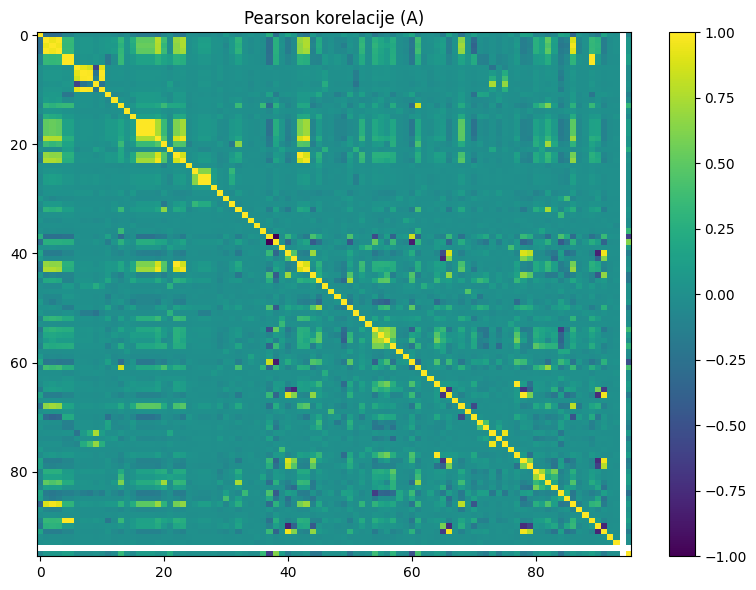

In [ ]:
corr_a_p = df_a_raw[num_a].corr(method="pearson")
plt.figure(figsize=(8,6))
plt.imshow(corr_a_p.values, aspect="auto")
plt.colorbar()
plt.title("Pearson korelacije (A)")
plt.tight_layout()
plt.show()

In [ ]:
def vif_table(df, cols, max_cols=20):
    cols = [c for c in cols if df[c].dropna().nunique() > 2][:max_cols]
    X = df[cols].dropna()
    X = (X - X.mean()) / (X.std() + 1e-9)
    X = sm.add_constant(X)
    v = []
    for i, c in enumerate(X.columns):
        if c == "const":
            continue
        try:
            v.append((c, float(sm.stats.outliers_influence.variance_inflation_factor(X.values, i))))
        except Exception:
            v.append((c, np.nan))
    return pd.DataFrame(v, columns=["stupac","VIF"]).sort_values("VIF", ascending=False)

vif_table(df_a_raw, num_a, max_cols=20).head(15)

,stupac,VIF
0,ROA(C) before interest and depreciation befor...,NaN
1,ROA(A) before interest and % after tax,NaN
2,ROA(B) before interest and depreciation after...,NaN
3,Operating Gross Margin,NaN
4,Realized Sales Gross Margin,NaN
5,Operating Profit Rate,NaN
6,Pre-tax net Interest Rate,NaN
7,After-tax net Interest Rate,NaN
8,Non-industry income and expenditure/revenue,NaN
9,Continuous interest rate (after tax),NaN


## 6. Predobrada: MICE imputacija, outlieri, encoding i integracija skupova

In [ ]:
def detect_target_a(df):
    for c in ["Bankrupt?","bankrupt","target","Target","y","Y"]:
        if c in df.columns:
            return c
    raise KeyError("Ciljni stupac nije pronađen u skupu A.")

def detect_target_b(df):
    candidates = ["default","Default","target","Target","SeriousDlqin2yrs","BAD","bad","Risk","risk","loan_default","LoanDefault"]
    for c in candidates:
        if c in df.columns:
            return c
    return None

target_a = detect_target_a(df_a_raw)
target_b = detect_target_b(df_b_raw)

(target_a, target_b)

('Bankrupt?', 'default')

In [ ]:
df_a = df_a_raw.copy()
y_a = df_a[target_a].astype(int)
X_a = df_a.drop(columns=[target_a])

df_b = df_b_raw.copy()
if target_b is None:
    raise KeyError(f"Ciljni stupac nije prepoznat u skupu B. Dostupni stupci: {list(df_b.columns)[:120]}")
y_b = df_b[target_b].astype(int)
X_b = df_b.drop(columns=[target_b])

(X_a.shape, X_b.shape, y_a.mean(), y_b.mean())

((6819, 95), (5000, 12), np.float64(0.03226279513125092), np.float64(0.0978))

In [ ]:
def iqr_clip_fit(X, num_cols, k=1.5):
    q1 = X[num_cols].quantile(0.25)
    q3 = X[num_cols].quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi

def iqr_clip_transform(X, num_cols, lo, hi):
    X2 = X.copy()
    X2[num_cols] = X2[num_cols].clip(lo, hi, axis=1)
    return X2

def add_isoforest_flag(X, num_cols):
    Xn = X[num_cols].copy()
    Xn = Xn.replace([np.inf, -np.inf], np.nan)
    Xn = Xn.fillna(Xn.median())
    iso = IsolationForest(n_estimators=200, contamination="auto", random_state=SEED)
    flag = (iso.fit_predict(Xn.values) == -1).astype(int)
    return flag

num_a2, cat_a2 = split_types(X_a)
num_b2, cat_b2 = split_types(X_b)

Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_a, y_a, test_size=0.2, stratify=y_a, random_state=SEED)
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_b, y_b, test_size=0.2, stratify=y_b, random_state=SEED)

lo_a, hi_a = iqr_clip_fit(Xa_tr, num_a2, k=1.5)
lo_b, hi_b = iqr_clip_fit(Xb_tr, num_b2, k=1.5)

Xa_tr2 = iqr_clip_transform(Xa_tr, num_a2, lo_a, hi_a)
Xa_te2 = iqr_clip_transform(Xa_te, num_a2, lo_a, hi_a)
Xb_tr2 = iqr_clip_transform(Xb_tr, num_b2, lo_b, hi_b)
Xb_te2 = iqr_clip_transform(Xb_te, num_b2, lo_b, hi_b)

Xa_tr2["outlier_flag"] = add_isoforest_flag(Xa_tr2, num_a2)
Xa_te2["outlier_flag"] = add_isoforest_flag(Xa_te2, num_a2)
Xb_tr2["outlier_flag"] = add_isoforest_flag(Xb_tr2, num_b2)
Xb_te2["outlier_flag"] = add_isoforest_flag(Xb_te2, num_b2)

Xa_tr2.shape, Xb_tr2.shape

((5455, 96), (4000, 13))

In [ ]:
def make_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([
        ("imp", IterativeImputer(random_state=SEED, max_iter=20, sample_posterior=False)),
        ("sc", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

num_a3, cat_a3 = split_types(Xa_tr2)
num_b3, cat_b3 = split_types(Xb_tr2)

prep_a = make_preprocessor(num_a3, cat_a3)
prep_b = make_preprocessor(num_b3, cat_b3)

Za_tr = prep_a.fit_transform(Xa_tr2)
Za_te = prep_a.transform(Xa_te2)

Zb_tr = prep_b.fit_transform(Xb_tr2)
Zb_te = prep_b.transform(Xb_te2)

Za_tr.shape, Zb_tr.shape

((5455, 96), (4000, 18))

In [ ]:
def napravi_predprocesor(numericki_stupci, kategorijski_stupci):
    numericki_pipeline = Pipeline([
        ("imputacija", IterativeImputer(random_state=SEED, max_iter=20, sample_posterior=False)),
        ("skaliranje", StandardScaler())
    ])
    if len(kategorijski_stupci) == 0:
        return ColumnTransformer([
            ("num", numericki_pipeline, numericki_stupci)
        ])
    kategorijski_pipeline = Pipeline([
        ("imputacija", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num", numericki_pipeline, numericki_stupci),
        ("kat", kategorijski_pipeline, kategorijski_stupci)
    ])

def nazivi_znacajki(predprocesor):
    numericki_stupci = list(predprocesor.transformers_[0][2])
    kategorijski_stupci = list(predprocesor.transformers_[1][2]) if len(predprocesor.transformers_) > 1 else []
    if len(kategorijski_stupci) == 0:
        return numericki_stupci
    kat_pipeline = predprocesor.transformers_[1][1]
    onehot = kat_pipeline.named_steps["onehot"]
    return numericki_stupci + onehot.get_feature_names_out(kategorijski_stupci).tolist()

numericki_a, kategorijski_a = split_types(Xa_tr2)
numericki_b, kategorijski_b = split_types(Xb_tr2)

pred_a = napravi_predprocesor(numericki_a, kategorijski_a)
pred_b = napravi_predprocesor(numericki_b, kategorijski_b)

Za_tr = pred_a.fit_transform(Xa_tr2)
Za_te = pred_a.transform(Xa_te2)

Zb_tr = pred_b.fit_transform(Xb_tr2)
Zb_te = pred_b.transform(Xb_te2)

nazivi_a = nazivi_znacajki(pred_a)
nazivi_b = nazivi_znacajki(pred_b)

Za_tr.shape, len(nazivi_a), Zb_tr.shape, len(nazivi_b), len(kategorijski_b)


((5455, 96), 96, (4000, 18), 18, 2)

In [ ]:
fa = nazivi_a
fb = nazivi_b

Xa_tr_enc = pd.DataFrame(Za_tr.toarray() if hasattr(Za_tr, "toarray") else Za_tr, columns=fa)
Xa_te_enc = pd.DataFrame(Za_te.toarray() if hasattr(Za_te, "toarray") else Za_te, columns=fa)
Xb_tr_enc = pd.DataFrame(Zb_tr.toarray() if hasattr(Zb_tr, "toarray") else Zb_tr, columns=fb)
Xb_te_enc = pd.DataFrame(Zb_te.toarray() if hasattr(Zb_te, "toarray") else Zb_te, columns=fb)

Xa_tr_enc["dataset"] = "A"
Xa_te_enc["dataset"] = "A"
Xb_tr_enc["dataset"] = "B"
Xb_te_enc["dataset"] = "B"

X_tr = pd.concat([Xa_tr_enc, Xb_tr_enc], axis=0, join="outer", ignore_index=True).fillna(0.0)
X_te = pd.concat([Xa_te_enc, Xb_te_enc], axis=0, join="outer", ignore_index=True).fillna(0.0)

y_tr = pd.concat([pd.Series(ya_tr).reset_index(drop=True), pd.Series(yb_tr).reset_index(drop=True)], ignore_index=True)
y_te = pd.concat([pd.Series(ya_te).reset_index(drop=True), pd.Series(yb_te).reset_index(drop=True)], ignore_index=True)

X_tr.shape, X_te.shape, y_tr.mean(), y_te.mean()

((9455, 114),
 (2364, 114),
 np.float64(0.059968270756213644),
 np.float64(0.06006768189509306))

In [ ]:
dataset_oh = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ds_tr = dataset_oh.fit_transform(X_tr[["dataset"]])
ds_te = dataset_oh.transform(X_te[["dataset"]])

X_tr2 = X_tr.drop(columns=["dataset"]).astype(float).values
X_te2 = X_te.drop(columns=["dataset"]).astype(float).values

X_tr_final = np.hstack([X_tr2, ds_tr])
X_te_final = np.hstack([X_te2, ds_te])

feat_final = list(X_tr.drop(columns=["dataset"]).columns) + dataset_oh.get_feature_names_out(["dataset"]).tolist()

X_tr_final.shape, X_te_final.shape, len(feat_final)

((9455, 115), (2364, 115), 115)

## 7. Selekcija značajki (RFE) i baseline modeli (LR, RF)

In [ ]:
lr_base = LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced", random_state=SEED)
rfe = RFE(estimator=lr_base, n_features_to_select=min(60, X_tr_final.shape[1]//2), step=0.1)
rfe.fit(X_tr_final, y_tr)

mask = rfe.support_
X_tr_sel = X_tr_final[:, mask]
X_te_sel = X_te_final[:, mask]
feat_sel = [f for f, m in zip(feat_final, mask) if m]

X_tr_sel.shape, X_te_sel.shape, len(feat_sel)

((9455, 57), (2364, 57), 57)

In [ ]:
def eval_model(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    p = model.predict_proba(Xte)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xte)
    auc = roc_auc_score(yte, p)
    ap = average_precision_score(yte, p)
    pr, rc, th = precision_recall_curve(yte, p)
    f1s = (2*pr*rc/(pr+rc+1e-12))
    best_i = int(np.nanargmax(f1s[:-1])) if len(th) else 0
    t = float(th[best_i]) if len(th) else 0.5
    yhat = (p >= t).astype(int)
    f1 = f1_score(yte, yhat)
    cm = confusion_matrix(yte, yhat)
    return {"AUC": float(auc), "PR_AUC": float(ap), "thr_f1": t, "F1": float(f1), "CM": cm.tolist()}

res_lr = eval_model(LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced", random_state=SEED), X_tr_sel, y_tr, X_te_sel, y_te)
res_rf = eval_model(RandomForestClassifier(n_estimators=600, random_state=SEED, class_weight="balanced_subsample"), X_tr_sel, y_tr, X_te_sel, y_te)

{"LR": res_lr, "RF": res_rf}

{'LR': {'AUC': 0.7909113094408032,
  'PR_AUC': 0.21640076783306722,
  'thr_f1': 0.7294295976149925,
  'F1': 0.25660377358490566,
  'CM': [[2133, 89], [108, 34]]},
 'RF': {'AUC': 0.6256417895310659,
  'PR_AUC': 0.11891959275300688,
  'thr_f1': 0.14166666666666666,
  'F1': 0.2564102564102564,
  'CM': [[1990, 232], [87, 55]]}}

## 8. XGBoost + Optuna (Bayesova optimizacija)

In [ ]:
N_TRIALS = 40
N_SPLITS = 5

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 50.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "random_state": SEED,
        "n_jobs": -1
    }
    pos = float((y_tr == 0).sum() / max(1, (y_tr == 1).sum()))
    params["scale_pos_weight"] = pos

    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    scores = []
    for tr_idx, va_idx in cv.split(X_tr_sel, y_tr):
        Xtr, Xva = X_tr_sel[tr_idx], X_tr_sel[va_idx]
        ytr2, yva = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
        m = XGBClassifier(**params)
        m.fit(Xtr, ytr2)
        p = m.predict_proba(Xva)[:,1]
        scores.append(average_precision_score(yva, p))
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

study.best_value, study.best_params

[I 2026-01-22 21:29:43,522] A new study created in memory with name: no-name-84cb84fc-0aa4-469d-b0cc-3ab0a405ad11
[I 2026-01-22 21:29:48,202] Trial 0 finished with value: 0.19913139068729208 and parameters: {'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.19442457407259517, 'subsample': 0.8051669776347057, 'colsample_bytree': 0.9688485601983842, 'min_child_weight': 0.04099556935505475, 'reg_lambda': 0.7911685674975155, 'reg_alpha': 0.15728185867174446, 'gamma': 0.5784255003792271}. Best is trial 0 with value: 0.19913139068729208.
[I 2026-01-22 21:29:56,274] Trial 1 finished with value: 0.21033563571588748 and parameters: {'n_estimators': 249, 'max_depth': 6, 'learning_rate': 0.02824416505334774, 'subsample': 0.6464111147964893, 'colsample_bytree': 0.6410795810214498, 'min_child_weight': 0.24449347616059583, 'reg_lambda': 0.0019589726877256588, 'reg_alpha': 0.12200682048575848, 'gamma': 2.97859696531853}. Best is trial 1 with value: 0.21033563571588748.
[I 2026-01-22 21:30:02,09

(0.24331752801039225,
 {'n_estimators': 277,
  'max_depth': 6,
  'learning_rate': 0.013566580827721325,
  'subsample': 0.826787914634774,
  'colsample_bytree': 0.7740429232243206,
  'min_child_weight': 7.32169356489187,
  'reg_lambda': 0.5132879828954985,
  'reg_alpha': 7.983897331072068,
  'gamma': 3.1669196445094596})

In [ ]:
best = study.best_params.copy()
pos = float((y_tr == 0).sum() / max(1, (y_tr == 1).sum()))
best.update({
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "random_state": SEED,
    "n_jobs": -1,
    "scale_pos_weight": pos
})

xgb_best = XGBClassifier(**best)
res_xgb = eval_model(xgb_best, X_tr_sel, y_tr, X_te_sel, y_te)
res_xgb

{'AUC': 0.792079207920792,
 'PR_AUC': 0.24642367894893655,
 'thr_f1': 0.7201992869377136,
 'F1': 0.26732673267326734,
 'CM': [[2189, 33], [115, 27]]}

<Figure size 640x480 with 0 Axes>

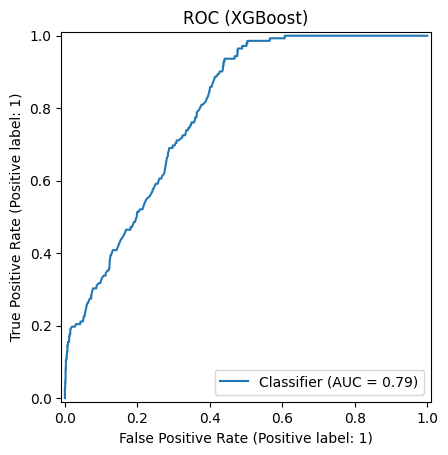

<Figure size 640x480 with 0 Axes>

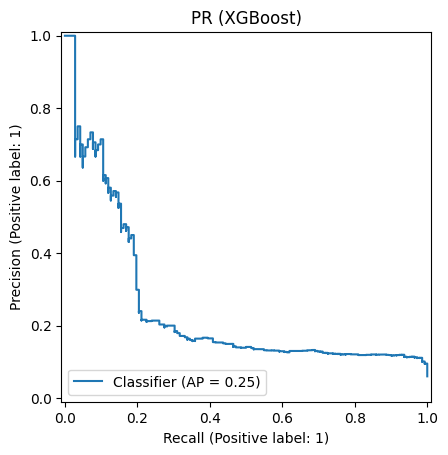

In [ ]:
xgb_best.fit(X_tr_sel, y_tr)
p = xgb_best.predict_proba(X_te_sel)[:,1]

plt.figure()
RocCurveDisplay.from_predictions(y_te, p)
plt.title("ROC (XGBoost)")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_te, p)
plt.title("PR (XGBoost)")
plt.show()

## 9. Nested cross-validation

In [ ]:
N_OUTER = 5
N_INNER_TRIALS = 15

outer = StratifiedKFold(n_splits=N_OUTER, shuffle=True, random_state=SEED)
outer_rows = []

for fold, (tr_idx, te_idx) in enumerate(outer.split(X_tr_sel, y_tr), start=1):
    Xo_tr, Xo_te = X_tr_sel[tr_idx], X_tr_sel[te_idx]
    yo_tr, yo_te = y_tr.iloc[tr_idx], y_tr.iloc[te_idx]

    def obj_inner(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 50.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "objective": "binary:logistic",
            "eval_metric": "aucpr",
            "random_state": SEED,
            "n_jobs": -1
        }
        posw = float((yo_tr == 0).sum() / max(1, (yo_tr == 1).sum()))
        params["scale_pos_weight"] = posw

        inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        s = []
        for a, b in inner.split(Xo_tr, yo_tr):
            m = XGBClassifier(**params)
            m.fit(Xo_tr[a], yo_tr.iloc[a])
            p2 = m.predict_proba(Xo_tr[b])[:,1]
            s.append(average_precision_score(yo_tr.iloc[b], p2))
        return float(np.mean(s))

    st = optuna.create_study(direction="maximize")
    st.optimize(obj_inner, n_trials=N_INNER_TRIALS, show_progress_bar=False)

    bp = st.best_params.copy()
    bp.update({
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "random_state": SEED,
        "n_jobs": -1,
        "scale_pos_weight": float((yo_tr == 0).sum() / max(1, (yo_tr == 1).sum()))
    })

    m = XGBClassifier(**bp)
    m.fit(Xo_tr, yo_tr)
    p3 = m.predict_proba(Xo_te)[:,1]
    outer_rows.append({
        "fold": fold,
        "AUC": float(roc_auc_score(yo_te, p3)),
        "PR_AUC": float(average_precision_score(yo_te, p3))
    })

nested_res = pd.DataFrame(outer_rows)
nested_res, nested_res.mean(numeric_only=True)

[I 2026-01-22 21:35:55,210] A new study created in memory with name: no-name-0c796909-4aba-44ae-ac9b-793b9e85c0ba
[I 2026-01-22 21:36:01,185] Trial 0 finished with value: 0.20463400113191219 and parameters: {'n_estimators': 586, 'max_depth': 5, 'learning_rate': 0.031147502382006607, 'subsample': 0.6068813546544727, 'colsample_bytree': 0.6357379832937186, 'min_child_weight': 0.01501866974101528, 'reg_lambda': 0.009874368538937068, 'reg_alpha': 5.204780437682192, 'gamma': 3.4746239274603163}. Best is trial 0 with value: 0.20463400113191219.
[I 2026-01-22 21:36:05,092] Trial 1 finished with value: 0.15492610919942731 and parameters: {'n_estimators': 970, 'max_depth': 8, 'learning_rate': 0.16456765918247598, 'subsample': 0.9244363338773247, 'colsample_bytree': 0.826381524400409, 'min_child_weight': 1.8372911404941572, 'reg_lambda': 0.684322704661201, 'reg_alpha': 0.00014699392227808582, 'gamma': 2.2220048937014223}. Best is trial 0 with value: 0.20463400113191219.
[I 2026-01-22 21:36:08,14

(   fold       AUC    PR_AUC
 0     1  0.817146  0.252031
 1     2  0.809705  0.201384
 2     3  0.774162  0.170233
 3     4  0.815861  0.288969
 4     5  0.805917  0.267108,
 fold      3.000000
 AUC       0.804558
 PR_AUC    0.235945
 dtype: float64)

## 10. Prag odluke i profit funkcija

In [ ]:
p = xgb_best.predict_proba(X_te_sel)[:,1]
pr, rc, th = precision_recall_curve(y_te, p)

f1s = 2*pr*rc/(pr+rc+1e-12)
best_i = int(np.nanargmax(f1s[:-1])) if len(th) else 0
thr_f1 = float(th[best_i]) if len(th) else 0.5

yhat = (p >= thr_f1).astype(int)

thr_f1, f1_score(y_te, yhat), confusion_matrix(y_te, yhat).tolist()

(0.7201992869377136, 0.26732673267326734, [[2189, 33], [115, 27]])

In [ ]:
C_TP = 1.0
C_FP = -0.2
C_FN = -1.0
C_TN = 0.0

def profit(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = ((y_true==1)&(y_pred==1)).sum()
    fp = ((y_true==0)&(y_pred==1)).sum()
    fn = ((y_true==1)&(y_pred==0)).sum()
    tn = ((y_true==0)&(y_pred==0)).sum()
    return C_TP*tp + C_FP*fp + C_FN*fn + C_TN*tn

profits = []
for t in np.linspace(0.01, 0.99, 99):
    profits.append((t, profit(y_te, (p>=t).astype(int))))
best_t_profit = max(profits, key=lambda x: x[1])[0]

best_t_profit, max(profits, key=lambda x: x[1])[1]

(np.float64(0.4), np.float64(-72.0))

## 11. Kalibracija vjerojatnosti

In [ ]:
cal = CalibratedClassifierCV(xgb_best, method="isotonic", cv=3)
cal.fit(X_tr_sel, y_tr)

p_uncal = xgb_best.predict_proba(X_te_sel)[:,1]
p_cal = cal.predict_proba(X_te_sel)[:,1]

b_uncal = brier_score_loss(y_te, p_uncal)
b_cal = brier_score_loss(y_te, p_cal)

b_uncal, b_cal

(np.float64(0.1743190233935863), np.float64(0.09493546270956124))

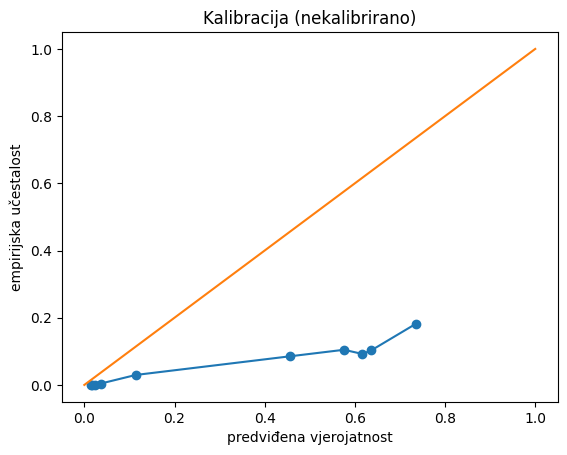

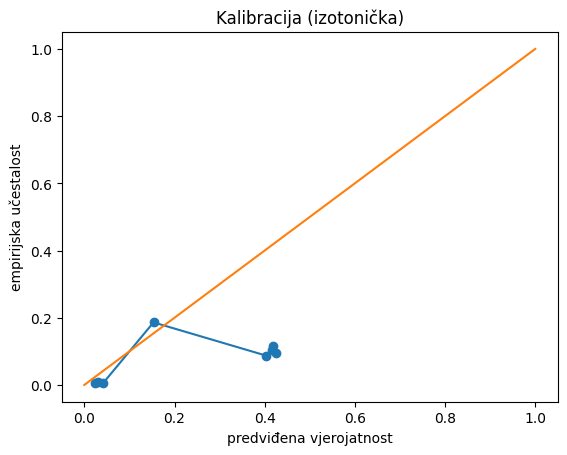

In [ ]:
frac_u, mean_u = calibration_curve(y_te, p_uncal, n_bins=10, strategy="quantile")
frac_c, mean_c = calibration_curve(y_te, p_cal, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(mean_u, frac_u, marker="o")
plt.plot([0,1],[0,1])
plt.xlabel("predviđena vjerojatnost")
plt.ylabel("empirijska učestalost")
plt.title("Kalibracija (nekalibrirano)")
plt.show()

plt.figure()
plt.plot(mean_c, frac_c, marker="o")
plt.plot([0,1],[0,1])
plt.xlabel("predviđena vjerojatnost")
plt.ylabel("empirijska učestalost")
plt.title("Kalibracija (izotonička)")
plt.show()

## 12. SHAP interpretabilnost

/tmp/ipython-input-4262762163.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_sample, feature_names=feat_sel, show=False)


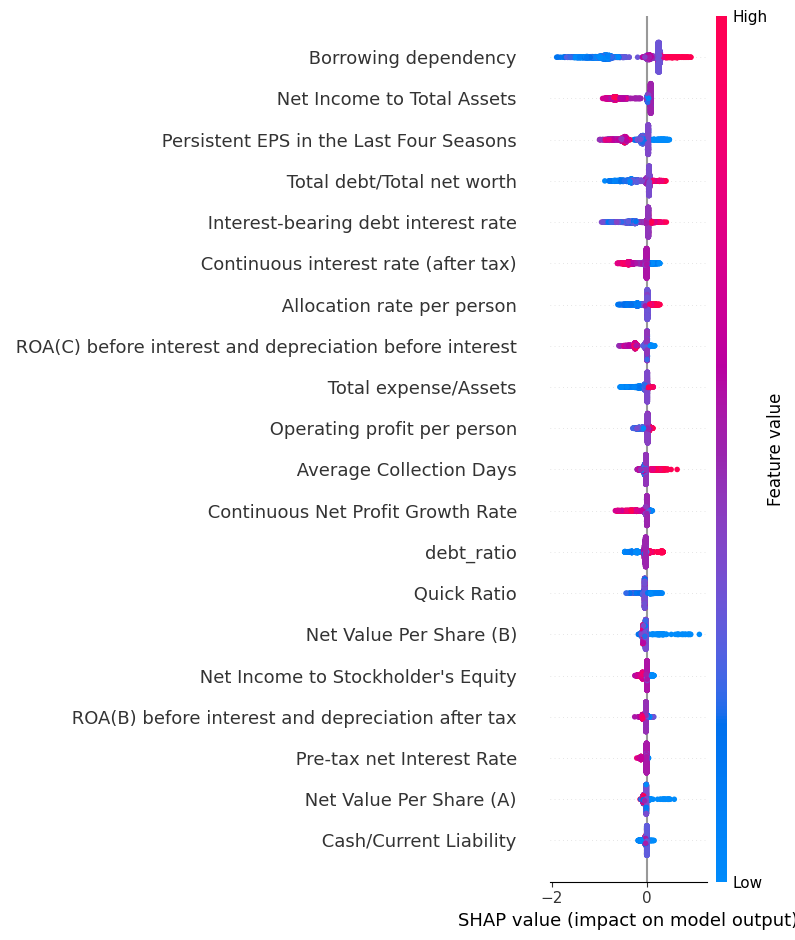

In [ ]:
expl = shap.TreeExplainer(xgb_best)
X_sample = X_te_sel[:2000]
sv = expl.shap_values(X_sample)

shap.summary_plot(sv, X_sample, feature_names=feat_sel, show=False)
plt.tight_layout()
plt.show()

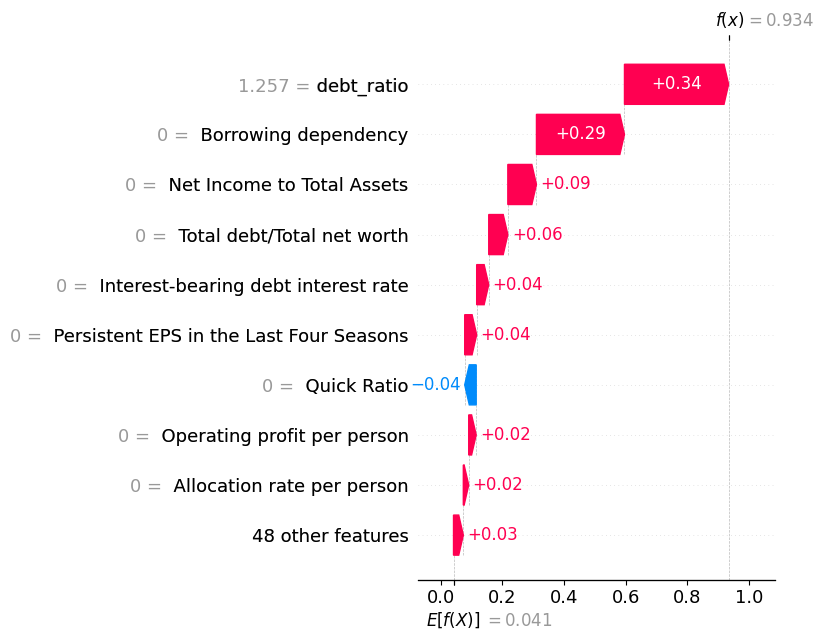

In [ ]:
idx = int(np.argmax(p_cal))
x1 = X_te_sel[idx:idx+1]
sv1 = expl.shap_values(x1)

shap.waterfall_plot(shap.Explanation(values=sv1[0], base_values=expl.expected_value, data=x1[0], feature_names=feat_sel), show=False)
plt.tight_layout()
plt.show()

## 13. K-means segmentacija

In [ ]:
Xk = X_tr_sel.copy()
yk = y_tr.to_numpy()

k_vals = list(range(2, 9))
sil = []
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    lab = km.fit_predict(Xk)
    sil.append(silhouette_score(Xk, lab))

k_best = int(pd.DataFrame({"k": k_vals, "sil": sil}).sort_values("sil", ascending=False).iloc[0]["k"])
k_best

3

In [ ]:
km = KMeans(n_clusters=k_best, random_state=SEED, n_init=10)
lab = km.fit_predict(Xk)

seg = pd.DataFrame({"klaster": lab, "default": yk})
seg.groupby("klaster")["default"].agg(["count","mean"]).rename(columns={"mean":"stopa_defaulta"})

,count,stopa_defaulta
klaster,,
0,1504,0.000000
1,6704,0.062798
2,1247,0.117081


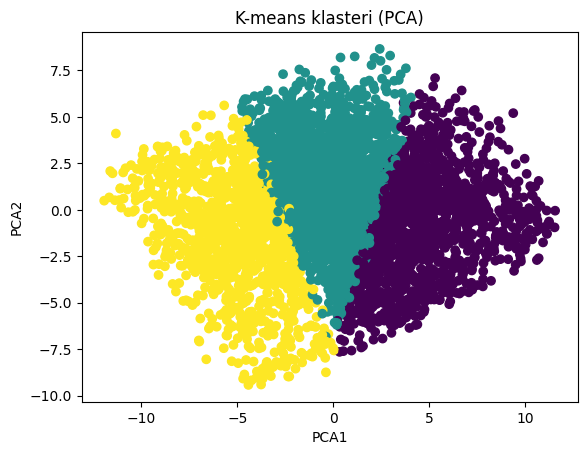

In [ ]:
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(Xk)

plt.figure()
plt.scatter(Z[:,0], Z[:,1], c=lab)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("K-means klasteri (PCA)")
plt.show()

## 14. Pohrana u SQLite

In [ ]:
DB = ROOT / "default_risk.db"
if DB.exists():
    DB.unlink()

con = sqlite3.connect(DB.as_posix())

df_train = pd.DataFrame(X_tr_sel, columns=feat_sel)
df_train["y"] = y_tr.to_numpy()
df_train.to_sql("train_selected", con, index=False)

df_test = pd.DataFrame(X_te_sel, columns=feat_sel)
df_test["y"] = y_te.to_numpy()
df_test.to_sql("test_selected", con, index=False)

pd.DataFrame([
    {"model":"LR", **{k:v for k,v in res_lr.items() if k!="CM"}, "CM": json.dumps(res_lr["CM"])},
    {"model":"RF", **{k:v for k,v in res_rf.items() if k!="CM"}, "CM": json.dumps(res_rf["CM"])},
    {"model":"XGB", **{k:v for k,v in res_xgb.items() if k!="CM"}, "CM": json.dumps(res_xgb["CM"])},
]).to_sql("metrics", con, index=False)

nested_res.to_sql("nested_cv", con, index=False)
pd.DataFrame([study.best_params]).to_sql("xgb_best_params", con, index=False)

con.close()

DB.as_posix()

'default_risk_repo/default_risk.db'

## 15. REST API (FastAPI)

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
import uvicorn
import threading
import requests

In [ ]:
app = FastAPI()

class PredictIn(BaseModel):
    features: dict

def read_sql(table):
    con = sqlite3.connect(DB.as_posix())
    try:
        return pd.read_sql_query(f"SELECT * FROM {table}", con)
    finally:
        con.close()

@app.get("/health")
def health():
    return {"status": "ok"}

@app.get("/metrics")
def metrics():
    df = read_sql("metrics")
    return df.to_dict(orient="records")

@app.get("/nested")
def nested():
    df = read_sql("nested_cv")
    return df.to_dict(orient="records")

@app.post("/predict")
def predict(inp: PredictIn):
    x = np.zeros(len(feat_sel), dtype=float)
    for i, f in enumerate(feat_sel):
        if f in inp.features:
            x[i] = float(inp.features[f])
    p = float(cal.predict_proba(x.reshape(1,-1))[:,1][0])
    return {"p_default": p}

In [ ]:
nest_asyncio.apply()

def start_server():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

t = threading.Thread(target=start_server, daemon=True)
t.start()

import time
ok = False
for _ in range(30):
    try:
        r = requests.get("http://127.0.0.1:8000/health", timeout=0.5)
        if r.status_code == 200:
            ok = True
            break
    except Exception:
        time.sleep(0.2)

ok

True

In [ ]:
requests.get("http://127.0.0.1:8000/metrics").json()[:3]

[{'model': 'LR',
  'AUC': 0.7909113094408032,
  'PR_AUC': 0.21640076783306722,
  'thr_f1': 0.7294295976149925,
  'F1': 0.25660377358490566,
  'CM': '[[2133, 89], [108, 34]]'},
 {'model': 'RF',
  'AUC': 0.6256417895310659,
  'PR_AUC': 0.11891959275300688,
  'thr_f1': 0.14166666666666666,
  'F1': 0.2564102564102564,
  'CM': '[[1990, 232], [87, 55]]'},
 {'model': 'XGB',
  'AUC': 0.792079207920792,
  'PR_AUC': 0.24642367894893655,
  'thr_f1': 0.7201992869377136,
  'F1': 0.26732673267326734,
  'CM': '[[2189, 33], [115, 27]]'}]

In [ ]:
example = {feat_sel[i]: float(df_test.iloc[0, i]) for i in range(min(10, len(feat_sel)))}
requests.post("http://127.0.0.1:8000/predict", json={"features": example}).json()

{'p_default': 0.32491716866691905}

## 16. Kritički osvrt i zaključak

- Heterogeni formati (CSV/XLSX) povećavaju realističnost pipelinea; integracija se radi kroz union one-hot prostora i indikator izvora.
- MICE imputacija poboljšava predikcijsku vrijednost kod nedostajućih podataka, ali povećava složenost; fit mora biti strogo na trainu.
- Outlieri se ne uklanjaju agresivno, već se kodiraju kroz `outlier_flag`.
- Nested CV daje realniju procjenu generalizacije uz povećan trošak.
- SHAP omogućuje komunikaciju modela prema poslovnim dionicima.
- K-means daje segmentacijski sloj koji pomaže u razumijevanju profila rizika.

Zaključno, implementiran je end-to-end sustav: podaci, predobrada, modeliranje, optimizacija, kalibracija, interpretabilnost, segmentacija, pohrana i API.


## 17. Literatura (IEEE)

[1] Kaggle, “Company Bankruptcy Prediction,” dataset. Dostupno: Kaggle (slug: `fedesoriano/company-bankruptcy-prediction`).  
[2] Kaggle, “Credit Risk Modelling Dataset,” dataset. Dostupno: Kaggle (slug: `abhirajmandal/credit-risk-modelling-dataset`).  
[3] T. Chen i C. Guestrin, “XGBoost: A Scalable Tree Boosting System,” Proc. 22nd ACM SIGKDD, 2016.  
[4] T. Akiba et al., “Optuna: A Next-generation Hyperparameter Optimization Framework,” KDD, 2019.  
[5] S. M. Lundberg i S.-I. Lee, “A Unified Approach to Interpreting Model Predictions,” NeurIPS, 2017.  
[6] F. Pedregosa et al., “Scikit-learn: Machine Learning in Python,” JMLR, 2011.  
[7] DVC, “Data Version Control,” službena dokumentacija.  
[8] FastAPI, “FastAPI,” službena dokumentacija.
